In [25]:
import awkward as ak
import numpy as np
import hist
from coffea import processor
from coffea.nanoevents.methods import candidate
import uproot
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
from coffea.lookup_tools import extractor
import mplhep as hep
import matplotlib.pyplot as plt
import numba


@numba.njit
def clusterfillerhelper(llps, clusts):
    z = []
    r = []
    for llpevent, clustevent in zip(llps, clusts):
        for llp in llpevent:
            for clust in clustevent:
                if np.sqrt((llp.Eta - clust.Eta)**2 + (llp.Phi - clust.Phi)**2) < .4:
                    z.append(abs(clust.Z))
                    r.append(clust.R)
    return z, r

class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        dim = {
            'csc':{},
            'dt':{},
            'cms':{},
        }
        dim['csc']['zmin'] = 6500
        dim['csc']['zmax'] = 10000
        dim['csc']['rmin'] = 0
        dim['csc']['rmax'] = 7000
        dim['dt']['zmin'] = 0
        dim['dt']['zmax'] = 6500
        dim['dt']['rmin'] = 4000
        dim['dt']['rmax'] = 7500
        
        dim['cms']['zmin'] = 0
        dim['cms']['zmax'] = 12000
        dim['cms']['rmin'] = 0
        dim['cms']['rmax'] = 8000
        
        dataset = events.metadata['dataset']
        sumw = ak.sum(events.Weight)
        
        def R(p):
            x = p.X
            y = p.Y
            return np.sqrt(x**2 + y**2)
    
        def dictbuilder(dr, name):
            dic = ak.zip(
            {
                'X': dr.X, ##make sure to ask, are these the correct variables?
                'Y': dr.Y,
                'Z': dr.Z, 
                'R': R(dr),
                'Eta': dr.Eta,
                'Phi': dr.Phi
                },
                with_name = name,
                behavior = candidate.behavior,                 
            )
            return dic

        llps = dictbuilder(events.llp, 'llps')
        cscs = dictbuilder(events.CscCluster130, 'cscs')
        
        def hister(bins, region):
            return (
                    hist.Hist.new
                    .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
                    .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
                    .Double()
                   )    

        
        bins = 30
        llpDecayHist = hister(bins, region = 'cms')
        llpCscDecayHist = hister(bins, region = 'cms')
        cscClusterHist = hister(bins, region = 'cms')
        
        #cuts data within csc region         
        def cscCutter(p):
            cut = (
                    (abs(p.Eta) < 2.4) & 
                    (abs(p.Z) > dim['csc']['zmin']) & (abs(p.Z) < dim['csc']['zmax']) &
                    (p.R < dim['csc']['rmax'])
                  )
            return p[cut]

        #hist filler
        def filler(hist, p):
            z = abs(ak.flatten(p.Z, axis = None))
            r = ak.flatten(p.R, axis = None)
            hist.fill(z = z, r = r)
            
        def clusterfiller(hist, llps, clusts):
            z, r = clusterfillerhelper(llps, clusts)
            hist.fill(z = z, r = r)
           
        filler(llpDecayHist, llps)
        filler(llpCscDecayHist, llps)
        #clusterfiller(cscClusterHist, llps, cscs)
        filler(cscClusterHist, cscs)
        
        return {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
                "llpDecayHist": llpDecayHist,
                
                "llpCscDecayHist": llpCscDecayHist,
                "cscClusterHist": cscClusterHist,
                
                #"llpDtDecayHist": llpDtDecayHist,
                #"dtClusterHist": dtClusterHist
            }
        }

    def postprocess(self, accumulator):
        return accumulator

def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list



In [26]:
address = 'root://cmsxrootd.fnal.gov/'
filedir   = address + "/store/user/christiw/BDecay_delphes/v5/hadd/"
fileset = {
           '1e1mm': [filedir + "m1_ct10mm.root"],
           '1e2mm': [filedir + "m1_ct100mm.root"],
           '1e3mm': [filedir + "m1_ct1000mm.root"],
           '1e4mm': [filedir + "m1_ct10000mm.root"]
          }
treename  = "Delphes"

In [27]:
out = processor.run_uproot_job(
    fileset,
    treename = treename,
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": DelphesSchema, "workers": 4},
    maxchunks=30,
)
out

Processing:   0%|          | 0/4 [00:00<?, ?chunk/s]

{'1e3mm': {'entries': 10000,
  'sumw': 30000.0000078664,
  'llpDecayHist': Hist(
    Regular(30, 0, 12000, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 8000, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 10180.0 (15000.0 with flow),
  'llpCscDecayHist': Hist(
    Regular(30, 0, 12000, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 8000, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 10180.0 (15000.0 with flow),
  'cscClusterHist': Hist(
    Regular(30, 0, 12000, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 8000, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 200.0},
 '1e2mm': {'entries': 10000,
  'sumw': 30000.00000295566,
  'llpDecayHist': Hist(
    Regular(30, 0, 12000, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 8000, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 11430.0 (13570.0 with flow),
  'llpCscDecayHist': Hist(
    Regular(30, 0, 12000, name='z', label='z d

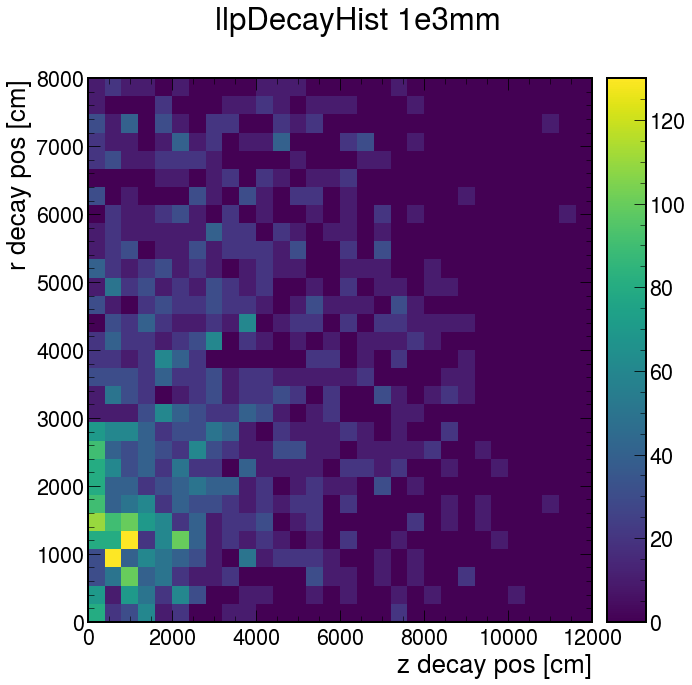

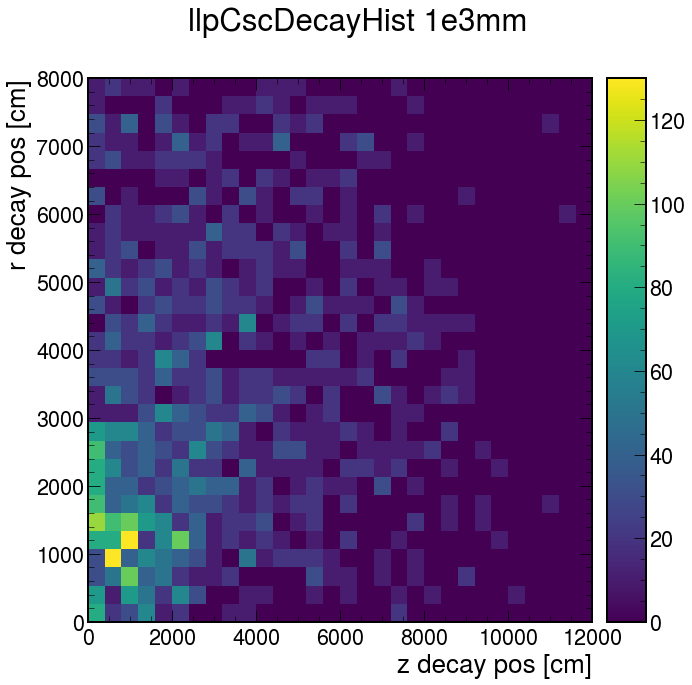

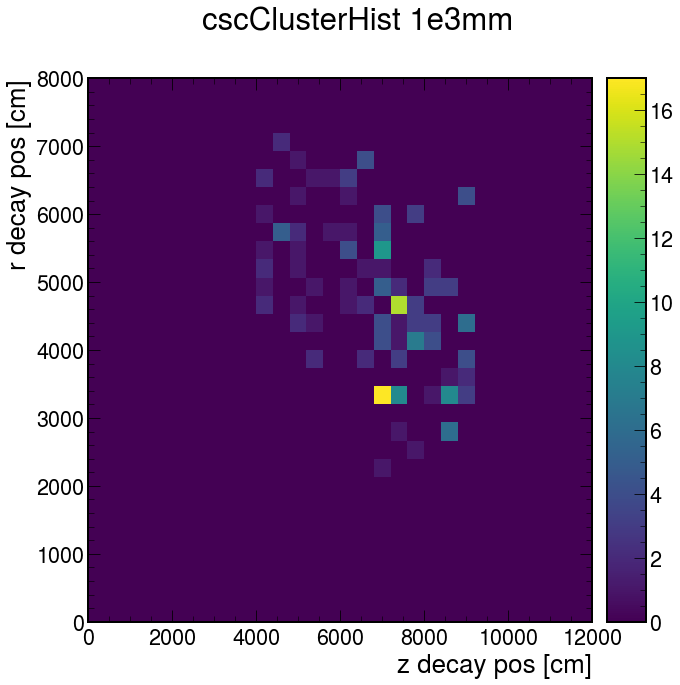

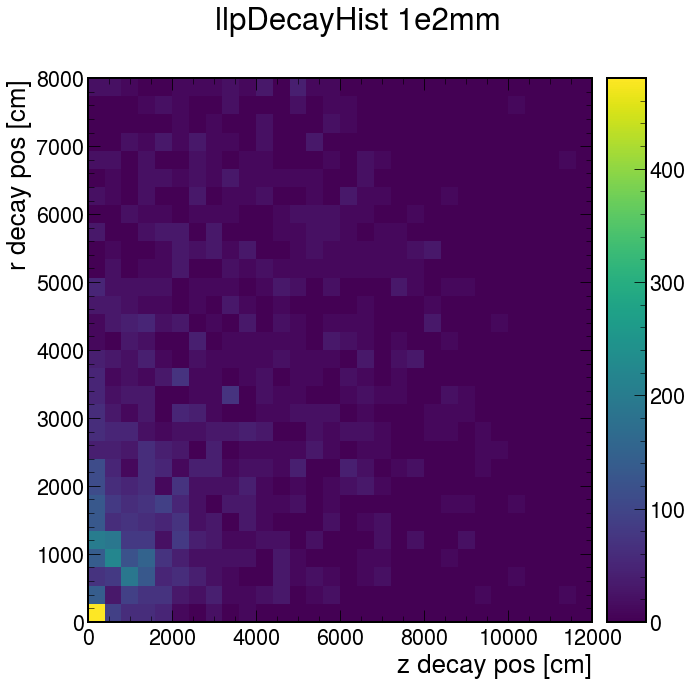

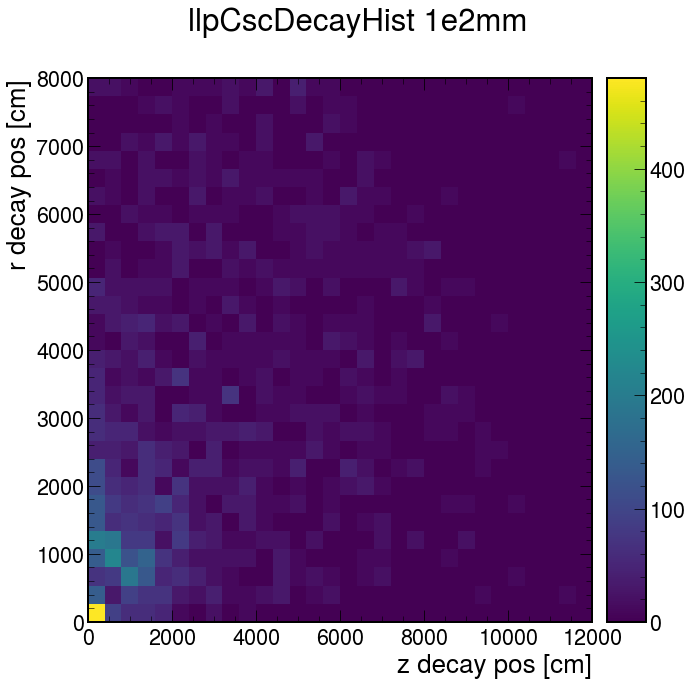

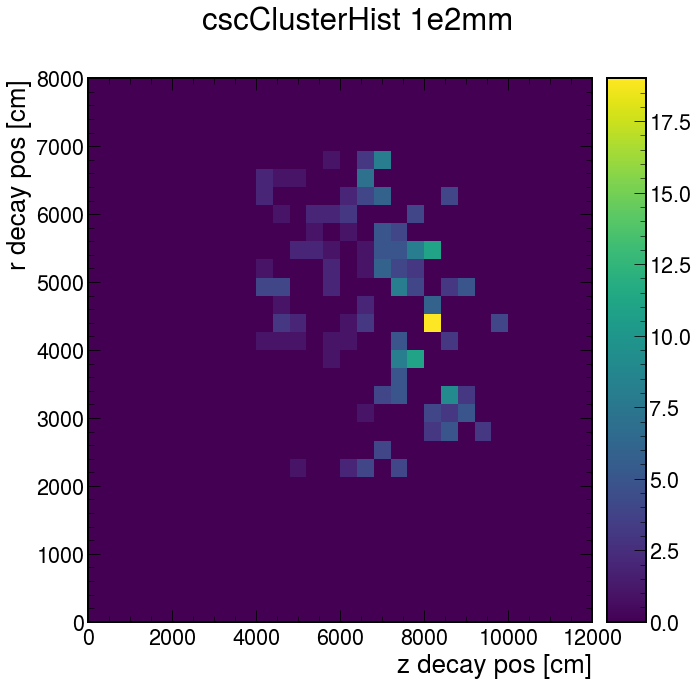

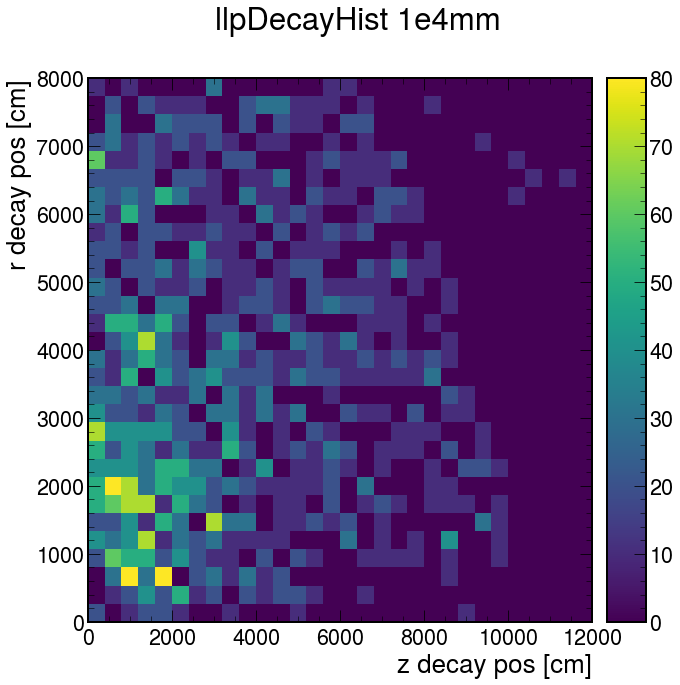

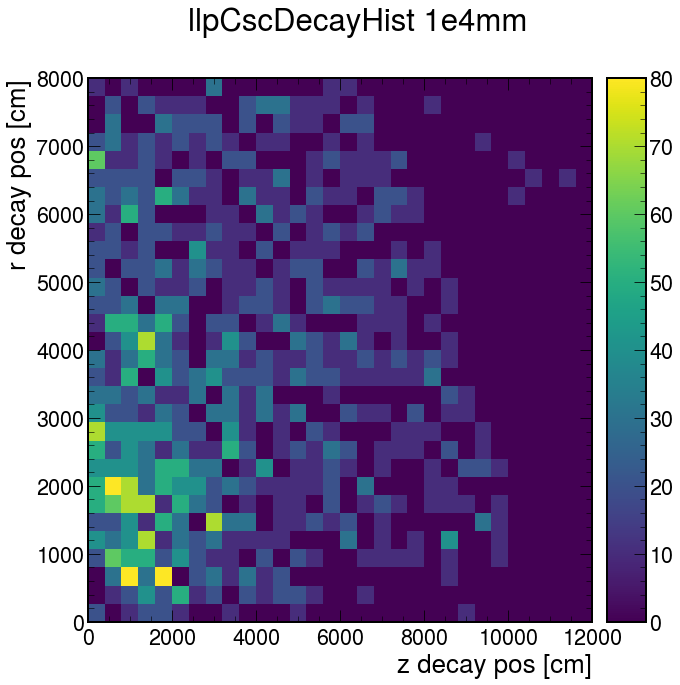

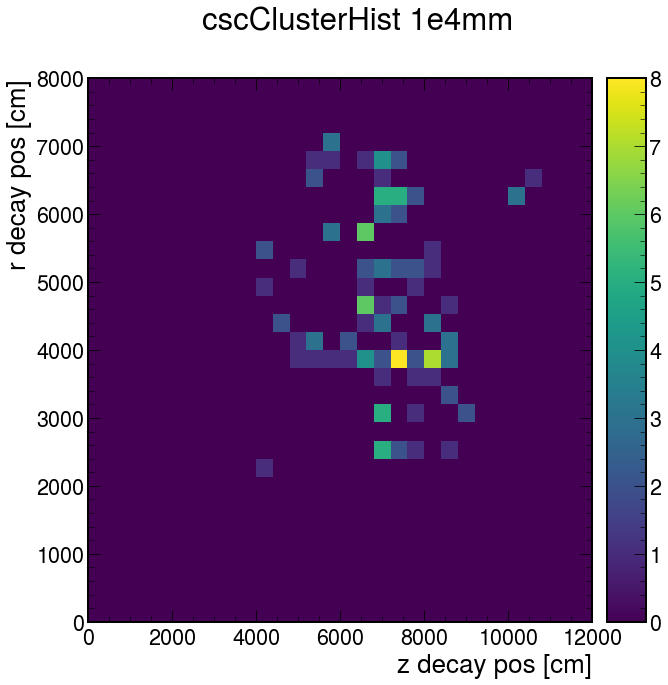

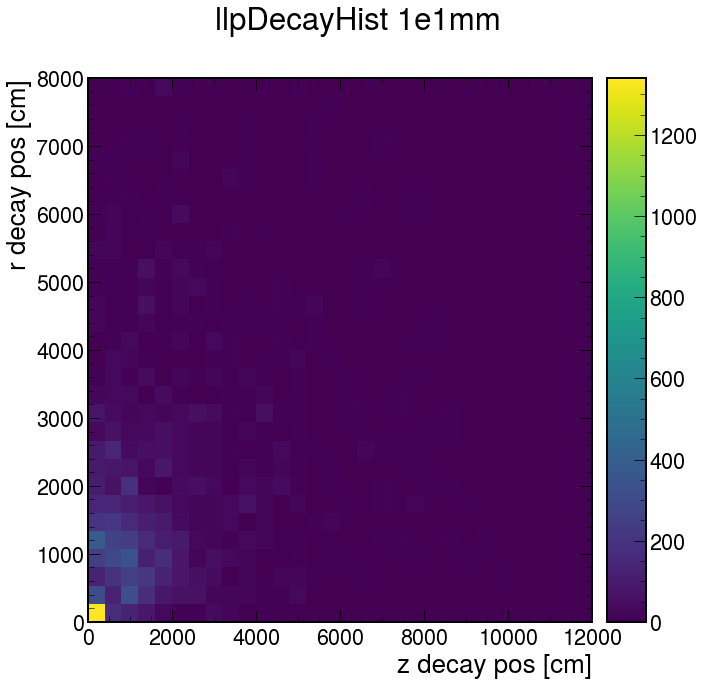

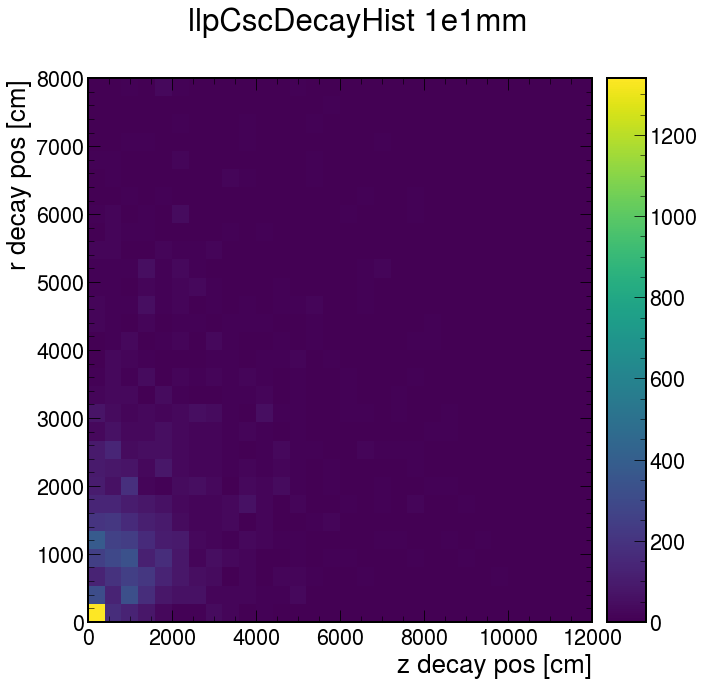

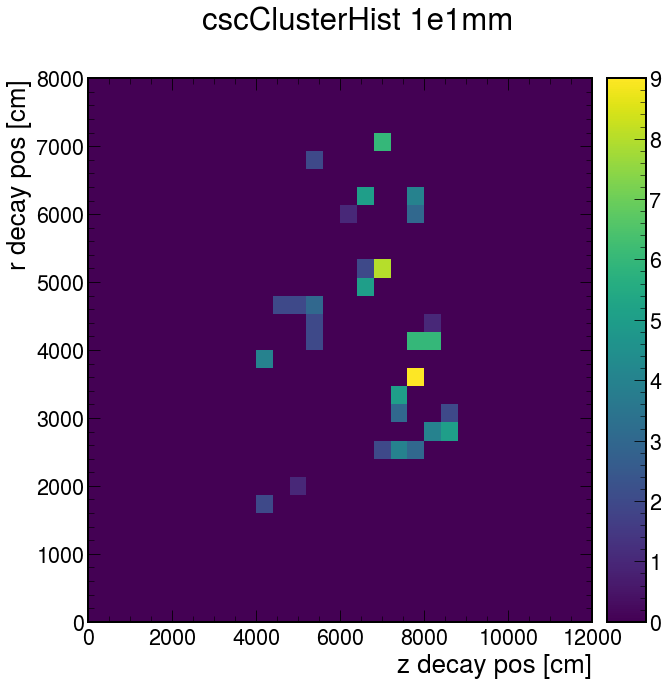

In [28]:
hep.style.use("CMS")
for junk in out:
    for jazz in out[junk]:
        if isinstance(out[junk][jazz], hist.Hist):
            fig, ax = plt.subplots()
            hep.hist2dplot(out[junk][jazz])
            fig.suptitle(f'{jazz} {junk}')

In [11]:
filename = fileset['1e1mm'][0]
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath=treename,
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=DelphesSchema,
).events()

In [15]:
events.CscCluster130.fields

['fUniqueID',
 'fBits',
 'NHits',
 'Eta',
 'Phi',
 'PT',
 'Px',
 'Py',
 'Pz',
 'E',
 'Ehad',
 'Eem',
 'pid',
 'T',
 'X',
 'Y',
 'Z',
 'R',
 'beta',
 'ctau']

In [33]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "poisson"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(5500,10750)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 5680-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((6320, 0), 390, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((7240, 0), 650, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((8490, 0), 620, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((9700, 0), 320, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((10500, 0),500, 2,color='grey',alpha=0.3)

    ax.text(5700, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(6700, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(8000, y_max*1.02, 'ME2', fontsize=12)
    ax.text(9200, y_max*1.02, 'ME3', fontsize=12)
    ax.text(10150, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+50 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-200,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(3500,linestyle="--",color='grey')
    ax.text(3500-1400,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(3500+150 ,y_max*0.9, "Outer ring", fontsize=15)
    return ax

/tmp/ipykernel_23257/3973375042.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


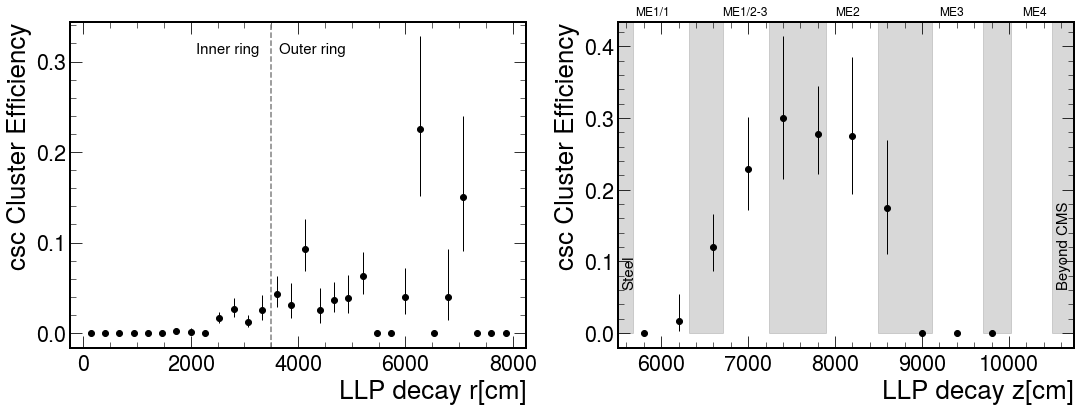

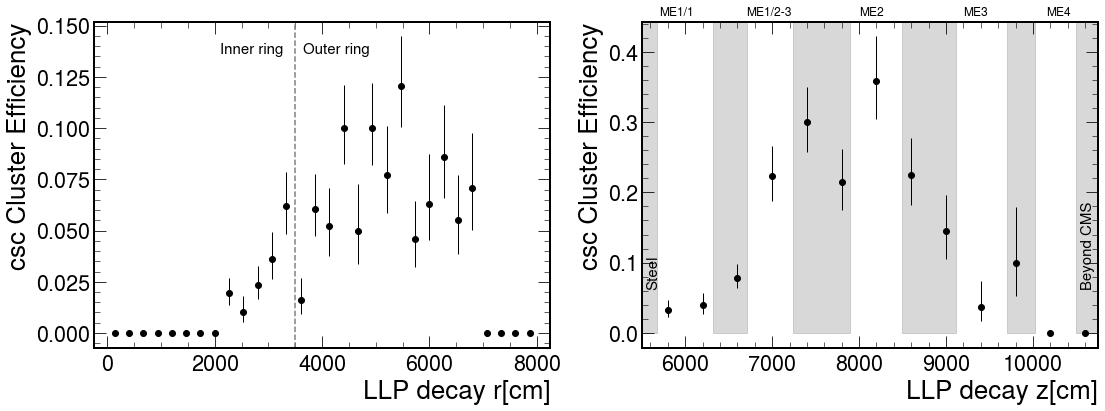

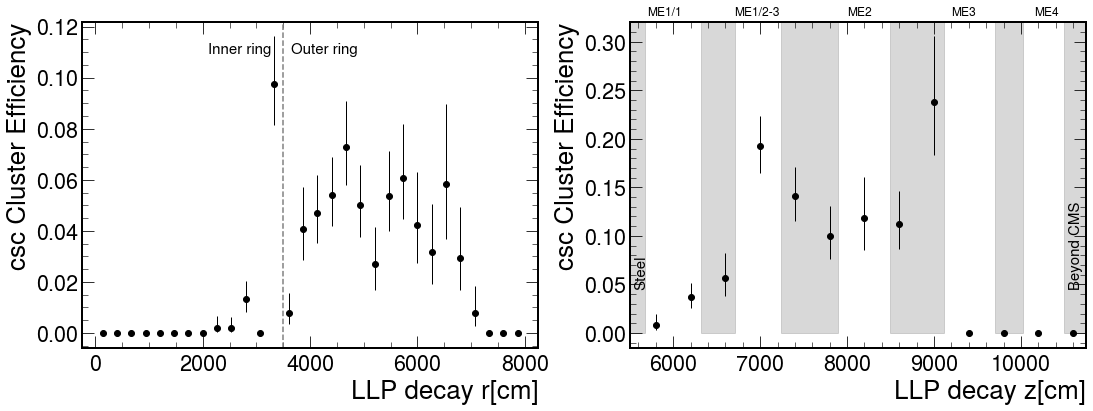

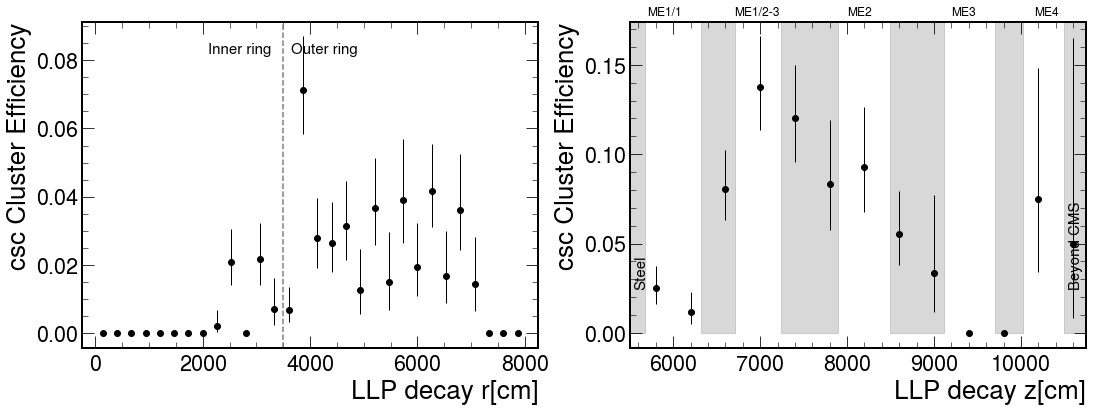

In [34]:
for sample in fileset:
    figsize = (18,6)
    fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

    csc = out[sample]['cscClusterHist']
    cscllp = out[sample]['llpCscDecayHist']

    ratio(csc, cscllp, csczax, 'z', 'csc')
    drawCSCz(csczax)

    ratio(csc, cscllp, cscrax, 'r', 'csc')
    drawCSCr(cscrax)
    fig.savefig(sample + '.pdf')